# Variational inference for diffusion processes

Typically, the posterior of stochastic differential equation (SDE) models cannot be computed in closed form. Therefore, if are modelling some temporal data using an SDE, and are looking to compute the posterior of the model, we will have to resort to approximations. Here we discuss a method {cite}`archambeau2007gaussian` {cite}`archambeau2008variational` for approximating the posterior of an SDE, by fitting another approximating SDE to it.

In [177]:
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
css_style = open('../../../_static/custom_style.css', 'r').read()
HTML(f'<style>{css_style}</style>')

## Two SDE models

Suppose we wish to model some data using an SDE with noisy observations of the form

$$\begin{align}
dx &= f(x, t) dt + \Sigma d\beta\\
y &\sim \mathcal{N}(0, r^2 I).
\end{align}$$

where $\beta$ is a standard Brownian motion. Given observations $\mathcal{D} = \{t_k, y_k\}_{k = 1}^K$, we are interested in approximating the posterior process $p(x, t | \mathcal{D})$. For most choices of $f(x, t)$, working with this SDE analytically is be impossible. Instead, we will approximate the posterior of this SDE with another stochastic process, described by the SDE

$$\begin{align}
dx &= g(x, t) dt + \Sigma d\beta, \text{ where } g(x, t) = -A(t)x(t) + b(t).
\end{align}$$

The motivation behind this particular form is that because this SDE is linear, it corresponds to a Gaussian Process (GP) whose marginal mean and variance can be treated almost entirely in analytic form. In particular, this mean and variance can be shown to exactly obey two ODEs which, even though cannot be solved in closed form, can be well approximated using numerical integration.

## Approximating via the Free Energy

Because the approximating SDE has an affine drift function $g$ and a constant noise term, it is a Gaussian Process (GP). The marginal mean and variance, $m(t)$ and $S(t)$, of this GP statisfy{cite}`sarkka2019applied` the ODEs

$$\begin{align}
\dot{m}(t) &= -A(t)m(t) + b(t), \\
\dot{S}(t) &= -A(t)S(t) -S(t)A(t)^\top + \Sigma.
\end{align}$$

We are therefore interested finding $A(t)$ and $b(t)$ such that the distribution of $x$ under this SDE, approximates the distribution of $x$ under the posterior process. Let us write $q(x, t)$ for the distribution of $x$ at time $t$ according to the approximating SDE and $p(x, t)$ for the prior of the exact SDE - we will often abbreviate these by $q(x)$ and $p(x)$. We will fit $A, b$ by minimising the free energy

$$\begin{align}
\mathcal{F}(A, b) &= \sum_{k = 1}^K \int q(x_k) \log p(y_k | x_k) dx_k - KL\left[q || p\right].
\end{align}$$

We cannot compute this free energy in closed form, so we approximate it with a discretisation. Then letting the discretisation resolution go to $0$ we come close to an analytic expression for the KL-divergence between the prior and the approximating SDE.

<div class="lemma">
    
**Lemma (KL-divergence between $p$ and $q$)** The KL-divergence between the prior and approximating SDEs can be written as
    
$$\begin{align}
KL\left[q || p\right] &= KL\left[q(x_0) || p(x_0)\right] + \frac{1}{2}\int^{t_1}_{t_0} \int q(x_n) (f(x, t) - g(x, t))^\top \Sigma^{-1}(f(x, t) - g(x, t)) dx_n dt. \\
\end{align}$$
    
</div>
<br>

<details class="proof">
<summary>Proof: KL-divergence between \(p\) and \(q\)</summary>

<div>
    
Consider splitting the time interval $[t_0, t_1]$ into $N$ equal segments of size $\Delta t = \frac{t_1 - t_0}{N}$ and let the values of the SDE at the endpoints of these segments be $x_0, x_1, ..., x_N$. Then, the joint distribution at these points in time under the prior and approximating SDEs are

$$\begin{align}
p(x_0, ..., x_N) &\approx p(x_0) \prod_{n = 1}^N \mathcal{N}(x_{n+1} | x_n + f_n \Delta t, \Sigma \Delta t), \\
q(x_0, ..., x_N) &\approx p(x_0) \prod_{n = 1}^N \mathcal{N}(x_{n+1} | x_n + g_n \Delta t, \Sigma \Delta t).
\end{align}$$
    
We can then write the KL-divergence between these two multivariate distributions as    
    
$$\begin{align}
&KL[q(x_0, ..., x_N) || p(x_0, ..., x_N)] = \\
=~&KL\left[q(x_0) || p(x_0)\right] - \sum_{n = 1}^N \int\int q(x_{n+1}, x_n) \left[\log p(x_{n+1} | x_n) - \log q(x_{n+1} | x_n)\right]~dx_n dx_{n+1}~.
\end{align}$$
    
Evaluating the second term and taking the $\Delta t \to 0$ limit we obtain
    
$$\begin{align}
& \sum_{n = 1}^N \int\int q(x_{n+1}, x_n) \left[\log p(x_{n+1} | x_n) - \log q(x_{n+1} | x_n)\right]~dx_n  =\\
&= \frac{1}{2}\sum_{n = 1}^N \int\int q(x_{n+1}, x_n) \big[(x_{n+1} - x_n - f_n \Delta t)^\top (\Sigma \Delta t)^{-1}(x_{n+1} - x_n - f_n \Delta t) \\
&~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ - (x_{n+1} - x_n - g_n \Delta t)^\top (\Sigma \Delta t)^{-1}(x_{n+1} - x_n - g_n \Delta t) \big] ~dx_n dx_{n+1} \\
&= \frac{1}{2}\sum_{n = 1}^N \int q(x_{n+1}, x_n) \text{Tr}\big[(x_{n+1} - x_n - f_n \Delta t)(x_{n+1} - x_n - f_n \Delta t)^\top (\Sigma \Delta t)^{-1} \\
&~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ - (x_{n+1} - x_n - g_n \Delta t)(x_{n+1} - x_n - g_n \Delta t)^\top (\Sigma \Delta t)^{-1} \big] ~dx_n dx_{n+1} \\
&= \frac{1}{2}\sum_{n = 1}^N \int q(x_n) (f_n - g_n)^\top \Sigma^{-1}(f_n - g_n) dx_n \\
&\to \frac{1}{2}\int^{t_1}_{t_0} \int q(x_n) (f_n - g_n)^\top \Sigma^{-1}(f_n - g_n) dx_n dt.\\
\end{align}$$
 
</div>

</details>
<br>


Therefore, the free energy is equal to

$$\begin{align}
\mathcal{F}(\theta, A, b) &= \sum_{k = 1}^K \int q(x_k) \log p(y_k | x_k) dx_k + KL\left[q || p\right] \\
&= \sum_{k = 1}^K \int_{t_0}^{t_1} \underbrace{\int q(x_k) \log p(y_k | x_k) dx_k}_{= E_{obs}} \delta(t - t_k) dt + \int^{t_1}_{t_0} \underbrace{\frac{1}{2}\int q(x_n) (f_n - g_n)^\top \Sigma^{-1}(f_n - g_n) dx_n}_{= E_{sde}} dt + KL\left[q(x_0) || p(x_0)\right].
\end{align}$$

Therefore, we can minimise the free energy by introducing Lagrange mulitpliers $\lambda$ (a vector) and $\Psi$ (a symmetric matrix), enforcing these constraints and writing the Lagrangian $\mathcal{L}$ as

$$\begin{align}
\mathcal{L} = \mathcal{F}(\theta, A, b) - \int_{t_0}^{t_1} \lambda^\top(t)(\dot{m}(t) + A(t)m(t) - b(t)) dt - \int_{t_0}^{t_1} \text{Tr}\left[\Psi(t)(\dot{S}(t) + 2A(t)S(t) - \Sigma)\right] dt
\end{align}$$

Note that $\lambda(t_1)$ and $\Psi(t_1)$ can be set to $0$ since we only need the ODE constraints to be satisfied for $t_0 \leq t < t_1$. Applying the Euler-Lagrange equations for $A, b,  m, S$ we obtain four ODEs presented below - we ommit dependence on $t$ to lighten the notation. The first two ODEs are

$$\begin{align}
\frac{\partial E_{sde}}{\partial A} - \lambda^\top - 2\Psi S &= 0, \\
\frac{\partial E_{sde}}{\partial b} + \lambda &= 0,
\end{align}$$

and can be solved for $A$ and $b$, given $\lambda$ and $\Psi$. The second two are

$$\begin{align}
\dot{\lambda} &= - \frac{\partial E_{sde}}{\partial m} - \frac{\partial E_{obs}}{\partial m} + A^\top \lambda, \\
\dot{\Psi} &= - \frac{\partial E_{sde}}{\partial S} - \frac{\partial E_{obs}}{\partial S} + 2\Psi A.
\end{align}$$

and describe the evolution of $\lambda$ and $\Psi$ for given $A$ and $b$. First, we solve the equations forward for $m(t)$ and $S(t)$ for given $A(t), b(t)$ and initial conditions $m(t+0) = m_0, S(t+0) = S_0$. Then we solve backwards for $\lambda(t), \Psi(t)$ for given $m(t), S(t)$ and $A(t), b(t)$ with initial conditions $\lambda(t_1) = 0, \Psi(t_1) = 0$. We can then apply a gradient step to the parameters $A, b$ and repeat.

The derivatives of $E_{obs}$ involve $\delta$-functions at the locations where observations are present, so the following jump conditions must be applied at the observation times of the data

$$\begin{align}
\lambda(t_k^+) &= \lambda(t_k^-) - \frac{\partial E_{obs}}{\partial m}, \\
\Psi(t_k^+) &= \Psi(t_k^-) - \frac{\partial E_{obs}}{\partial S}.
\end{align}$$

(5, 5) 5


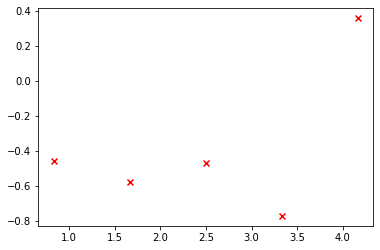

In [172]:
import numpy as np
from matplotlib import pyplot as plt

def ou_cov(sigma, gamma, t, t_):
    
    coeff = 0.5 * sigma ** 2 / gamma
    exp = np.exp(- gamma * np.abs(t[..., :, None] - t_[..., None, :]))
    
    return coeff * exp

t0 = 0.
t1 = 5.

sigma = 1.
gamma = 2.
r = 1e-1

num_train_pts = 5
grid_size = 10000
interval_size = int(grid_size / (num_train_pts + 1) - 1e-6)

np.random.seed(1)

t_grid = np.linspace(t0, t1, grid_size)
t_train = t_grid[::interval_size][1:-1]

x_mean = np.zeros((num_train_pts,))
x_cov = ou_cov(sigma=sigma, gamma=gamma, t=t_train, t_=t_train)
print(x_cov.shape, num_train_pts)
x_cov = x_cov + r ** 2 * np.eye(num_train_pts)

x_train = np.random.multivariate_normal(mean=x_mean, cov=x_cov)

plt.scatter(t_train, x_train, marker='x', color='red', zorder=2)
plt.show()

In [173]:
def forward(t_grid, m0, S0, b, A, Sigma, dt):
    
    grid_size = t_grid.shape[0]

    m = m0 * np.ones((grid_size, 1))
    S = S0 * np.ones((grid_size, 1, 1))
    
    for i in range(len(b) - 1):
        
        m[i + 1] = m[i] - (np.dot(A[i], m[i]) - b[i]) * dt
        S[i + 1] = S[i] - (np.dot(A[i], S[i]) + np.dot(S[i], A[i].T) - Sigma) * dt
        
    return m, S


def backward(t_grid, b, A, m, S, Sigma, gamma, r, psi, lamda, t_dict, x, dt):
    
    b_ = np.zeros_like(b)
    A_ = np.zeros_like(A)
    
#     print(psi[:, 0, 0])

    for i in range(len(b) - 1, 0, -1):
        
#         print(psi[:, 0, 0])
        
        coeff = (A[i] - gamma) ** 2 / Sigma
        dEds2 = 0.5 * coeff
        dEdm = coeff * m[i] - b[i] * (A[i] - gamma) / Sigma
        
        lamda[i - 1] = lamda[i] - (np.dot(A[i].T, lamda[i]) - dEdm) * dt
        psi[i - 1] = psi[i] - (2 * np.dot(psi[i], A[i]) - dEds2) * dt
        
        if t_grid[i - 1] in t_dict:
            psi[i - 1] = psi[i - 1] + 0.5 * r ** -2
            lamda[i - 1] = lamda[i - 1] - r ** -2 * (x[t_dict[t_grid[i - 1]]] - m[i - 1])
            
    for i in range(len(b) - 1, -1, -1):
        A_[i] = gamma + 2 * np.dot(Sigma, psi[i])
        b_[i] = - gamma * m[i] + np.dot(A_[i], m[i]) - np.dot(Sigma, lamda[i])
        
#     print(psi[:, 0, 0])
        
    return psi, lamda, b_, A_


def smoothing(t_train, t_grid, x_train, num_passes, omega, Sigma, gamma, r, dt):
    
    grid_size = t_grid.shape[0]
    
    # Dictionary mapping from times to indices for array x
    t_dict = dict(zip(t_train, np.arange(0, len(t_train))))
    
    b = np.zeros((grid_size, 1))
    A = np.zeros((grid_size, 1, 1))

    m = x_train[0] * np.ones((grid_size, 1))
    S = np.ones((grid_size, 1, 1))
    
    psi = None
    lamda = None
    
    for i in range(num_passes):

        lamda = np.zeros((grid_size, 1))
        psi = np.zeros((grid_size, 1, 1))
        
        # Forward pass to compute m, S
        m, S = forward(t_grid=t_grid, m0=0., S0=1e-1, b=b, A=A, Sigma=Sigma, dt=dt)
        
        # Backward pass to compute psi, lamda, b_, A_
        psi, lamda, b_, A_ = backward(t_grid=t_grid,
                                      b=b,
                                      A=A,
                                      m=m,
                                      S=S,
                                      Sigma=Sigma,
                                      gamma=gamma,
                                      r=r,
                                      psi=psi,
                                      lamda=lamda,
                                      t_dict=t_dict,
                                      x=x_train,
                                      dt=dt)
        
        b = b + omega * (b_ - b)
        A = A + omega * (A_ - A)

    return b, A, m, S, psi, lamda

In [174]:
num_passes = 20
Sigma = sigma ** 2 * np.eye(1)
omega = 5e-1

dt = (t1 - t0) / grid_size

b, A, m, S, psi, lamda = smoothing(t_train=t_train,
                                   t_grid=t_grid,
                                   x_train=x_train,
                                   num_passes=num_passes,
                                   omega=omega,
                                   Sigma=Sigma,
                                   gamma=gamma,
                                   r=r,
                                   dt=dt)



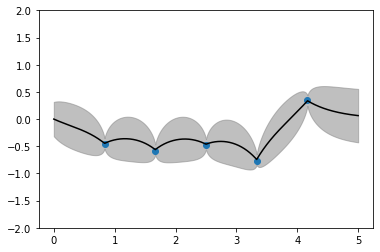

In [175]:
plt.plot(t_grid, m[:, 0], color='k')
plt.fill_between(t_grid,
                 m[:, 0] - S[:, 0, 0] ** 0.5,
                 m[:, 0] + S[:, 0, 0] ** 0.5,
                 color='gray',
                 alpha=0.5)
plt.scatter(t_train, x_train)
plt.ylim([-2, 2])
plt.show()

## References

```{bibliography} ./references.bib
```